In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Conv2D, MaxPool2D

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

https://velog.io/@oooops/CS231nConvolutional-Neural-Network

DNN : Fixed
CNN : image
RNN : sequence
    
mnist -> fasion mnist -> cifar-10 -> cifar-100 -> cifar1000

CNN

https://en.wikipedia.org/wiki/Convolution
-> 링크 내 공식 : y = w * x + b , w 에 t 시간의 변화가 추가되는 것

https://hunkim.github.io/ml/lec11.pdf

-> p.16 한칸씩 움직이는 것 Stride

-> 큰 이미지에서 작은 것을 filter(시간에 따라 변화), stride 하는 것을

=> Convolution

이미지 x, y, z 깊이인 z=색상. 2^z로 구분. 1이면 0,1로 흑백.

이미지 크기 감소 막기 위해서 (N - F) / Stride = 

그림 7 x 7이고 필터 3 x 3일때 주변을 0이나 1로 둘러 싸는 것을 Pad라고 함

7 - 3 = 4.  4/1 + 1 = 5
9 - 3 = 6.  6/1 + 1 = 7 그림의 크기가 커졌다.


필터를 통해 특징들만 뽑은 이미지. 필터의 개수 = 이미지의 개수.

필터를 가중치의 집합이라고도 부른다. a set of weight

# 1. Convolution 결과 이미지 확인

### (1) 샘플 이미지 준비

In [8]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

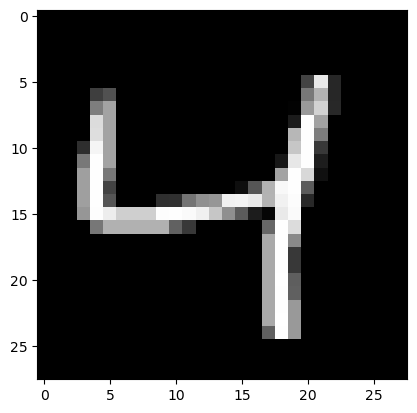

In [9]:
plt.imshow(X_train[2], cmap="gray")

## (2) 필터 준비

In [10]:
horizontal_filter = np.array([[1., 1., 1.],
                              [0., 0., 0.],
                              [-1., -1., -1.]])
vertical_filter = np.array([[1., 0., -1.],
                            [1., 0., -1.],
                            [1., 0., -1.]])
sharpen_filter = np.array([[0., -1., 0.],
                           [-1., 5., -1.],
                           [0., -1., 0.]])
blur_filter = np.array([[0.11, 0.11, 0.11],
                        [0.11, 0.11, 0.11],
                        [0.11, 0.11, 0.11]])
edge_1_filter = np.array([[1., 0., -1.],
                          [0., 0., 0.],
                          [-1., 0., 1.]])
edge_2_filter = np.array([[0., -1., 0.],
                          [-1., 4., -1.],
                          [0., -1., 0.]])
edge_3_filter = np.array([[-1., -1., -1.],
                          [-1., 8., -1.],
                          [-1., -1., -1.]])

## (3) Convolution 공식을 함수화

In [57]:
def conv2d_simple(input_image, filter, filter_size):
    original_image_size = input_image.shape[0]
    conv_output_size = int((original_image_size - filter_size) / 1 + 1)
    print(conv_output_size)

    filter_image = np.zeros((conv_output_size, conv_output_size))

    for i in range(conv_output_size):
        for j in range(conv_output_size):
            conv_result = input_image[i:(i+filter_size), j:(j+filter_size)] * filter
            conv_sum = np.sum(conv_result)

            if conv_sum > 255:
                conv_sum = 255

            filter_image[i, j] = conv_sum

    return filter_image

In [58]:
vertical_filter_image = conv2d_simple(X_train[2], vertical_filter, 3)

26


In [59]:
X_train[2].shape

(28, 28)

In [60]:
print(vertical_filter_image.shape)

(26, 26)


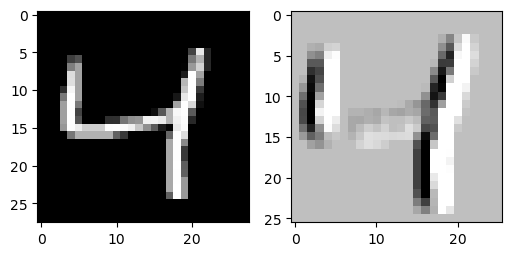

In [61]:
plt.figure(figsize=(6,4))

plt.subplot(1,2,1)
plt.imshow(X_train[2], cmap="gray")

plt.subplot(1,2,2)
plt.imshow(vertical_filter_image, cmap="gray")

In [62]:
horizontal_filter_image = conv2d_simple(X_train[2], horizontal_filter, 3)
vertical_filter_image = conv2d_simple(X_train[2], vertical_filter, 3)
sharpen_filter_image =conv2d_simple(X_train[2], sharpen_filter, 3)
blur_filter_image =conv2d_simple(X_train[2], blur_filter, 3)
edge_1_filter_image = conv2d_simple(X_train[2], edge_1_filter, 3)
edge_2_filter_image = conv2d_simple(X_train[2], edge_2_filter, 3)
edge_3_filter_image = conv2d_simple(X_train[2], edge_3_filter, 3)

26
26
26
26
26
26
26


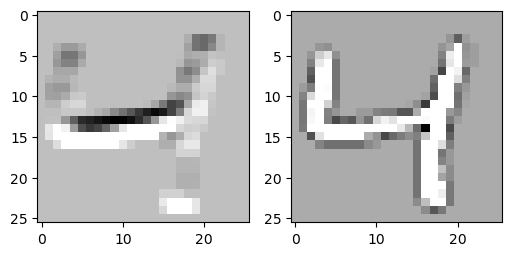

In [64]:
plt.figure(figsize=(6,4))

plt.subplot(1,2,1)
plt.imshow(horizontal_filter_image, cmap="gray")

plt.subplot(1,2,2)
plt.imshow(sharpen_filter_image, cmap="gray")

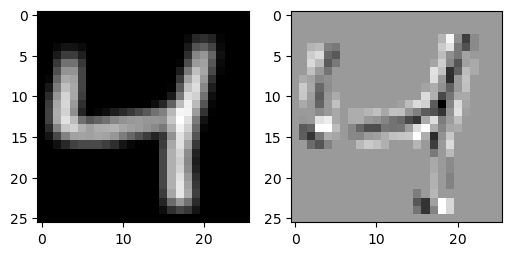

In [65]:
plt.figure(figsize=(6,4))

plt.subplot(1,2,1)
plt.imshow(blur_filter_image, cmap="gray")

plt.subplot(1,2,2)
plt.imshow(edge_1_filter_image, cmap="gray")

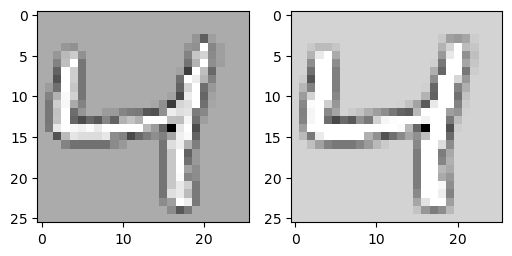

In [66]:
plt.figure(figsize=(6,4))

plt.subplot(1,2,1)
plt.imshow(edge_2_filter_image, cmap="gray")

plt.subplot(1,2,2)
plt.imshow(edge_3_filter_image, cmap="gray")

## (4) Max Pooling을 함수화

In [72]:
def maxpooling2d_simple(input_image):
    image_x = input_image.shape[0]
    image_y = input_image.shape[1]
    
    new_image_x = int(image_x / 2)
    new_image_y = int(image_y / 2)
    
    max_pool_image = np.zeros((new_image_x, new_image_y))
    
    for x in range(0, image_x, 2):
        for y in range(0, image_y, 2):
            max_pool_image[int(x/2), int(y/2)] = \
            np.max(input_image[x:x+2, y:y+2])
            
    return max_pool_image

In [79]:
vertical_filter_image = conv2d_simple(X_train[2], vertical_filter, 3)
print(vertical_filter_image.shape)

vertical_conv_pool_image = maxpooling2d_simple(vertical_filter_image)
print(vertical_conv_pool_image.shape)

print(vertical_conv_pool_image)

origin_pool_image = maxpooling2d_simple(X_train[2])
print(origin_pool_image.shape)
print(origin_pool_image)

26
(26, 26)
(13, 13)
[[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  232.   39.
     0.]
 [   0.  -62.  244.    0.    0.    0.    0.    0.    0. -187.  255.  118.
     0.]
 [   0. -407.  255.    0.    0.    0.    0.    0.    0. -285.  255.   79.
     0.]
 [   0. -323.  255.    0.    0.    0.    0.    0.    0.  255.  255.    0.
     0.]
 [   0.   88.  255.    0.    0.    0.    0.    0. -186.  255.  255.    0.
     0.]
 [   0.  205.  255.    0.  -49.   18.    0.   36. -332.  255.  255.    0.
     0.]
 [   0. -190.  242.    0.  124.  112.  107.  122. -331.  255.   40.    0.
     0.]
 [   0.    0.    0.    0.  121.   98.    0.    0.  255.  255.    0.    0.
     0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  255.  255.    0.    0.
     0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  164.  255.    0.    0.
     0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.  -25.  255.    0

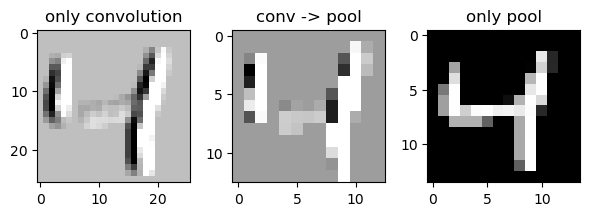

In [83]:
plt.figure(figsize=(6,4))

plt.subplot(1,3,1)
plt.title("only convolution")
plt.imshow(vertical_filter_image, cmap="gray")

plt.subplot(1,3,2)
plt.title("conv -> pool")
plt.imshow(vertical_conv_pool_image, cmap="gray")

plt.subplot(1,3,3)
plt.title("only pool")
plt.imshow(origin_pool_image, cmap="gray")

plt.tight_layout()

# 2. Basic CNN

- mnist
- https://m.blog.naver.com/bananacco/221928562116

conv : 특징추출
relu : 비선형
pool : 압축

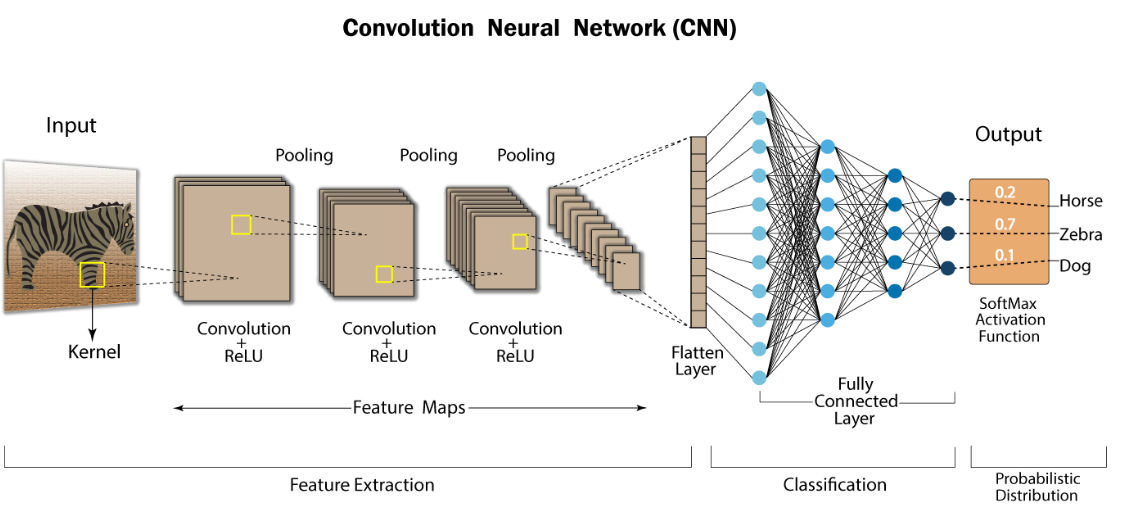

In [2]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train/255
X_test = X_test/255

In [4]:
print(X_train.shape, X_test.shape) # 3차원 # 28 x 28이 60000개

(60000, 28, 28) (10000, 28, 28)


In [12]:
# padding = "VALID"
# MaxPool2D(strides = None)
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=3, strides=(1,1), input_shape=(28, 28, 1),
                 padding="VALID", activation="relu"))
# filters = 필터 갯수
# kerner size = 가중치(W), 필터의 크기
# strides = (1,1) default
# padding
# input_shape = 처음들어오는 이미지값 + channels(입력되는 데이터의 갯수)
# input_shape = batch_shape + (channels, rows, cols)
# 컬러 이미지의 경우 R,G,B 채널이 3개이므로 입력 데이터는 (높이, 너비, 3)의 형태
# 흑백 이미지의 경우 R,G,B 채널이 1개이므로 입력 데이터는 (높이, 너비, 1)의 형태

model.add(MaxPool2D(pool_size=(2, 2), padding="VALID"))

model.add(Flatten())

model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


- Layer (type)                Output Shape              Param #   
- conv2d_1 (Conv2D)           (None, 26, 26, 32)        320    
- 320 = (3 * 3 * 1) * 32 + 32
- 3x3사이즈 필터가 흑백(1) x 32장 + 32
- 3x3사이즈 필터가 컬러(3) x 32장 + 32
- 5408 * 10 + 10 = 54090

(N - F) / stride + 1

(28 - 3) / 1 + 1 = 26

In [14]:
# padding = "same"
# MaxPool2D(strides = (1,1))
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=3, strides=(1,1), input_shape=(28, 28, 1),
                 padding="same", activation="relu"))
# filters = 필터 갯수
# kerner size = 가중치(W), 필터의 크기
# strides = (1,1) default
# padding
# input_shape = 처음들어오는 이미지값 + channels(입력되는 데이터의 갯수)
# input_shape = batch_shape + (channels, rows, cols)
# 컬러 이미지의 경우 R,G,B 채널이 3개이므로 입력 데이터는 (높이, 너비, 3)의 형태
# 흑백 이미지의 경우 R,G,B 채널이 1개이므로 입력 데이터는 (높이, 너비, 1)의 형태

model.add(MaxPool2D(pool_size=(2, 2), padding="same", strides=(1,1)))

model.add(Flatten())

model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 10)                250890    
                                                                 
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________


- padding = "same"으로 했더니 28, 28로 크기가 줄지 않았다
- pooling에서 strides=(1,1)의 경우 크기가 줄지 않았지만, 지정하지 않을경우 pool size로 지정된다
- pooling strides=none의 경우, pool_size=(2,2)이므로 Output Shape = (14, 14, 32)

In [20]:
model.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1873 - accuracy: 0.9299 - val_loss: 0.5731 - val_accuracy: 0.8672
Epoch 2/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1801 - accuracy: 0.9336 - val_loss: 0.5855 - val_accuracy: 0.8693
Epoch 3/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1719 - accuracy: 0.9363 - val_loss: 0.6049 - val_accuracy: 0.8694
Epoch 4/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1649 - accuracy: 0.9386 - val_loss: 0.7167 - val_accuracy: 0.8599
Epoch 5/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1582 - accuracy: 0.9414 - val_loss: 0.7448 - val_accuracy: 0.8648


In [21]:
model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.7731 - accuracy: 0.8715


[0.7731465697288513, 0.8715000152587891]

In [22]:
# padding = "same"
# MaxPool2D(strides = None)
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=3, strides=(1,1), input_shape=(28, 28, 1),
                 padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2, 2), padding="same"))

model.add(Flatten())

model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                62730     
                                                                 
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 9s 6ms/step - loss: 1.4802 - accuracy: 0.8334 - val_loss: 0.3628 - val_accuracy: 0.8743
Epoch 2/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3206 - accuracy: 0.8871 - val_loss: 0.3503 - val_accuracy: 0.8759
Epoch 3/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2852 - accuracy: 0.8989 - val_loss: 0.3811 - val_accuracy: 0.8737
Epoch 4/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2739 - accuracy: 0.9026 - val_loss: 0.3623 - val_accuracy: 0.8742
Epoch 5/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2640 - accuracy: 0.9049 - val_loss: 0.3616 - val_accuracy: 0.8843


In [24]:
model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3965 - accuracy: 0.8799


[0.39654481410980225, 0.8798999786376953]

## (2) Fashion MNIST

In [35]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [36]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [38]:
X_train[0] # 값이 0~255가 있으므로, 정규화를 위해서 255로 나누어준다

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [31]:
X_train = X_train/255
X_test = X_test/255

In [32]:
# padding = "VALID"
# MaxPool2D(strides = None)
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=3, strides=(1,1), input_shape=(28, 28, 1),
                 padding="VALID", activation="relu"))
# filters = 필터 갯수
# kerner size = 가중치(W), 필터의 크기
# strides = (1,1) default
# padding
# input_shape = 처음들어오는 이미지값 + channels(입력되는 데이터의 갯수)
# input_shape = batch_shape + (channels, rows, cols)
# 컬러 이미지의 경우 R,G,B 채널이 3개이므로 입력 데이터는 (높이, 너비, 3)의 형태
# 흑백 이미지의 경우 R,G,B 채널이 1개이므로 입력 데이터는 (높이, 너비, 1)의 형태

model.add(MaxPool2D(pool_size=(2, 2), padding="VALID"))

model.add(Flatten())

model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                54090     
                                                                 
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 10s 6ms/step - loss: 0.4752 - accuracy: 0.8337 - val_loss: 0.3588 - val_accuracy: 0.8712
Epoch 2/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3280 - accuracy: 0.8848 - val_loss: 0.3086 - val_accuracy: 0.8917
Epoch 3/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2897 - accuracy: 0.8980 - val_loss: 0.3067 - val_accuracy: 0.8919
Epoch 4/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2660 - accuracy: 0.9070 - val_loss: 0.2831 - val_accuracy: 0.9014
Epoch 5/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.2491 - accuracy: 0.9121 - val_loss: 0.2926 - val_accuracy: 0.8973


In [34]:
model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3080 - accuracy: 0.8889


[0.30804964900016785, 0.8888999819755554]

# 3. 오답 노트

In [42]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=3, strides=(1,1), input_shape=(28, 28, 1),
                 padding="SAME", activation="relu"))


model.add(MaxPool2D(pool_size=(2, 2), padding="SAME"))

model.add(Flatten())

model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                62730     
                                                                 
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_________________________________________________________________


In [43]:
result = model.fit(X_train.reshape(-1, 28, 28, 1), y_train, epochs=10, batch_size=50, validation_split=0.2)

Epoch 1/10
960/960 [==============================] - 8s 8ms/step - loss: 0.1452 - accuracy: 0.9551 - val_loss: 0.0783 - val_accuracy: 0.9764
Epoch 2/10
960/960 [==============================] - 7s 7ms/step - loss: 0.0676 - accuracy: 0.9792 - val_loss: 0.0770 - val_accuracy: 0.9773
Epoch 3/10
960/960 [==============================] - 7s 7ms/step - loss: 0.0499 - accuracy: 0.9841 - val_loss: 0.0804 - val_accuracy: 0.9783
Epoch 4/10
960/960 [==============================] - 7s 7ms/step - loss: 0.0405 - accuracy: 0.9871 - val_loss: 0.0890 - val_accuracy: 0.9788
Epoch 5/10
960/960 [==============================] - 7s 7ms/step - loss: 0.0303 - accuracy: 0.9900 - val_loss: 0.1012 - val_accuracy: 0.9747
Epoch 6/10
960/960 [==============================] - 7s 7ms/step - loss: 0.0270 - accuracy: 0.9913 - val_loss: 0.1150 - val_accuracy: 0.9749
Epoch 7/10
960/960 [==============================] - 7s 7ms/step - loss: 0.0239 - accuracy: 0.9921 - val_loss: 0.1175 - val_accuracy: 0.9775
Epoch 

In [44]:
model.evaluate(X_test.reshape(-1, 28, 28, 1), y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1282 - accuracy: 0.9802


[0.1282365918159485, 0.9801999926567078]

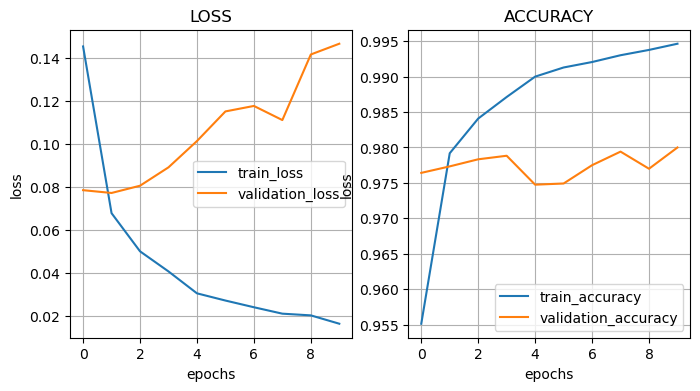

In [45]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

In [49]:
ret_val = model.predict(X_test.reshape(-1, 28, 28, 1))

313/313 [==============================] - 1s 3ms/step


In [50]:
print(ret_val.shape)
print(ret_val)

(10000, 10)
[[3.67477063e-30 1.03242604e-27 2.36155521e-25 ... 1.00000000e+00
  5.49643691e-18 5.50850904e-17]
 [2.06033820e-22 5.92271012e-21 1.00000000e+00 ... 3.15522173e-31
  5.00893789e-25 3.26054547e-26]
 [5.21370870e-14 1.00000000e+00 7.01848579e-11 ... 2.29433833e-11
  7.02549408e-10 3.38502352e-14]
 ...
 [6.13507053e-31 5.96732895e-25 3.12061777e-30 ... 1.13721324e-10
  3.84338460e-19 9.23981740e-15]
 [8.37471358e-31 4.66724995e-36 6.47047651e-35 ... 5.47436533e-24
  2.87179568e-11 6.43998149e-23]
 [4.68637520e-21 6.67381922e-32 8.74196821e-25 ... 6.17769828e-30
  2.87100335e-21 5.85346395e-28]]


In [53]:
# 정답을 알아보기 쉽게 인덱스 값으로 argmax
pred_val = np.argmax(ret_val, axis=1)
pred_comp_val = np.equal(pred_val, y_test)

In [54]:
pred_comp_val

array([ True,  True,  True, ...,  True,  True,  True])

In [57]:
index_label_pred_list = [[idx, y_test[idx], pred_val[idx]] for idx, result in enumerate(pred_comp_val) if result==False]

In [58]:
# 이미지의 위치, 이미지의 정답, 예측값
index_label_pred_list[0]

[96, 1, 4]

In [59]:
print(len(index_label_pred_list))

198


In [60]:
print(index_label_pred_list)

[[96, 1, 4], [175, 7, 9], [211, 5, 3], [247, 4, 6], [321, 2, 7], [340, 5, 3], [445, 6, 0], [449, 3, 5], [497, 4, 8], [619, 1, 8], [659, 2, 1], [667, 7, 9], [689, 7, 9], [717, 0, 6], [740, 4, 9], [844, 8, 7], [882, 9, 7], [883, 3, 5], [895, 0, 8], [924, 2, 7], [939, 2, 0], [947, 8, 9], [956, 1, 6], [1014, 6, 5], [1039, 7, 9], [1112, 4, 6], [1169, 5, 8], [1216, 7, 9], [1226, 7, 2], [1232, 9, 4], [1242, 4, 9], [1247, 9, 0], [1260, 7, 1], [1319, 8, 0], [1326, 7, 8], [1337, 2, 6], [1393, 5, 3], [1406, 5, 8], [1414, 9, 4], [1502, 8, 6], [1505, 7, 9], [1509, 4, 9], [1527, 1, 3], [1530, 8, 7], [1621, 0, 6], [1641, 5, 9], [1654, 2, 3], [1678, 2, 0], [1686, 8, 6], [1709, 9, 5], [1737, 5, 3], [1754, 7, 2], [1809, 7, 9], [1828, 3, 7], [1878, 8, 3], [1901, 9, 8], [1911, 5, 8], [2001, 5, 8], [2035, 5, 3], [2053, 4, 9], [2070, 7, 9], [2098, 2, 0], [2118, 6, 0], [2129, 9, 0], [2130, 4, 9], [2135, 6, 1], [2182, 1, 3], [2185, 0, 8], [2186, 2, 0], [2189, 9, 7], [2266, 1, 3], [2314, 7, 9], [2447, 4, 9], [

In [61]:
false_data_index = np.random.randint(len(index_label_pred_list))

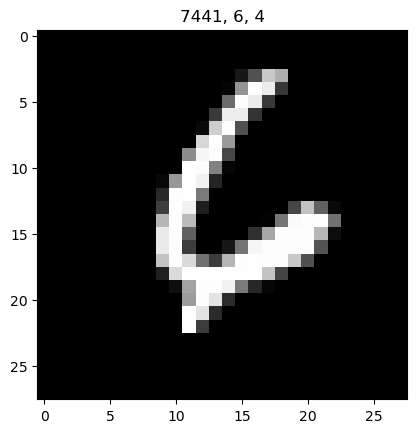

In [66]:
mnist_index = index_label_pred_list[false_data_index][0]
label = index_label_pred_list[false_data_index][1]
pred = index_label_pred_list[false_data_index][2]

img = X_test[mnist_index].reshape(28,28)

title = str(mnist_index) + ", " + str(label) + ", " + str(pred)
plt.title(title)
plt.imshow(img, cmap="gray")


# 4. Simple CNN

- C -> P -> C -> P -> F -> D -> D

In [82]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [83]:
model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(filters=32, kernel_size=3, padding="SAME", input_shape=(28,28,1), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 2nd Convolution Layer
model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(28,28,1), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)        

In [84]:
model.add(Flatten())

model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))

model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)        

In [85]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=1000)

Epoch 1/20
48/48 [==============================] - 12s 238ms/step - loss: 0.8130 - accuracy: 0.7277 - val_loss: 0.1165 - val_accuracy: 0.9648
Epoch 2/20
48/48 [==============================] - 11s 234ms/step - loss: 0.1100 - accuracy: 0.9658 - val_loss: 0.0603 - val_accuracy: 0.9817
Epoch 3/20
48/48 [==============================] - 12s 248ms/step - loss: 0.0785 - accuracy: 0.9749 - val_loss: 0.0524 - val_accuracy: 0.9846
Epoch 4/20
48/48 [==============================] - 12s 257ms/step - loss: 0.0635 - accuracy: 0.9800 - val_loss: 0.0491 - val_accuracy: 0.9846
Epoch 5/20
48/48 [==============================] - 12s 252ms/step - loss: 0.0554 - accuracy: 0.9826 - val_loss: 0.0468 - val_accuracy: 0.9857
Epoch 6/20
48/48 [==============================] - 12s 249ms/step - loss: 0.0491 - accuracy: 0.9838 - val_loss: 0.0419 - val_accuracy: 0.9872
Epoch 7/20
48/48 [==============================] - 12s 257ms/step - loss: 0.0445 - accuracy: 0.9862 - val_loss: 0.0396 - val_accuracy: 0.9887

In [86]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0359 - accuracy: 0.9892


[0.035896312445402145, 0.9891999959945679]

# 5. Deep CNN
- C, P, C, P , C, P, F, D, D

In [92]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [93]:
model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(filters=32, kernel_size=3, padding="SAME", input_shape=(28,28,1), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 2nd Convolution Layer
model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(28,28,1), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 3rd Convolution Layer
model.add(Conv2D(filters=128, kernel_size=3, padding="SAME", input_shape=(28,28,1), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 64)        

In [94]:
model.add(Flatten())

model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))

model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 64)        

In [95]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

In [96]:
result = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=1000)

Epoch 1/20
48/48 [==============================] - 16s 315ms/step - loss: 1.7480 - accuracy: 0.3650 - val_loss: 0.5997 - val_accuracy: 0.8280
Epoch 2/20
48/48 [==============================] - 15s 308ms/step - loss: 0.6166 - accuracy: 0.8002 - val_loss: 0.3890 - val_accuracy: 0.8890
Epoch 3/20
48/48 [==============================] - 15s 318ms/step - loss: 0.4515 - accuracy: 0.8554 - val_loss: 0.3085 - val_accuracy: 0.9128
Epoch 4/20
48/48 [==============================] - 15s 322ms/step - loss: 0.3984 - accuracy: 0.8720 - val_loss: 0.2526 - val_accuracy: 0.9302
Epoch 5/20
48/48 [==============================] - 16s 329ms/step - loss: 0.3659 - accuracy: 0.8817 - val_loss: 0.2529 - val_accuracy: 0.9253
Epoch 6/20
48/48 [==============================] - 16s 339ms/step - loss: 0.3666 - accuracy: 0.8816 - val_loss: 0.2822 - val_accuracy: 0.9187
Epoch 7/20
48/48 [==============================] - 16s 332ms/step - loss: 0.3429 - accuracy: 0.8887 - val_loss: 0.2449 - val_accuracy: 0.9282

In [97]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.1058 - accuracy: 0.9684


[0.10580624639987946, 0.9684000015258789]

# 6. 실습

In [ ]:
"""
1. Fashion mnist 사용
2. C P C P C P F D
3. 최소 90%이상의 성능
4. 과적합은 최소화
"""

In [ ]:
"""
1. Fashion mnist 사용
2. C C P C C P F D
3. 성능, 과적합 확인
"""

In [98]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 27s 0us/step


In [99]:

X_train = X_train/255
X_test = X_test/255

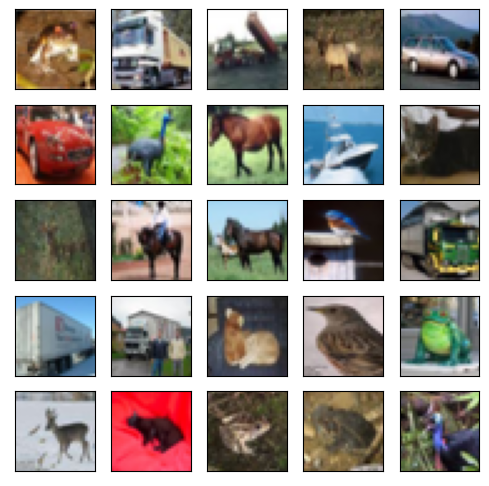

In [101]:
plt.figure(figsize=(6,6))

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [102]:
"""
1. CPCPCP, CCPCCPCPCP 등 다양한 아키텍처로 구현해서 과적합을 최소로하는 80%이상(87%만되도 잘하는거)
80%이상의 정확도를 가진 모델을 만든 후 저장

model.save("data/cifar10_accuracy_81v1.h5")

"""

'\n1. CPCPCP, CCPCCPCPCP 등 다양한 아키텍처로 구현해서 과적합을 최소로하는 80%이상(87%만되도 잘하는거)\n80%이상의 정확도를 가진 모델을 만든 후 저장\n\nmodel.save("data/cifar10_accuracy_81v1.h5")\n\n'

In [129]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()


X_train = X_train/255
X_test = X_test/255

In [130]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [131]:
X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

In [132]:
model = Sequential()

# 1st Convolution Layer
model.add(Conv2D(filters=64, kernel_size=3, padding="SAME", input_shape=(32,32,3), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 2nd Convolution Layer
model.add(Conv2D(filters=128, kernel_size=3, padding="SAME", input_shape=(32,32,3), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 3rd Convolution Layer
model.add(Conv2D(filters=256, kernel_size=3, padding="SAME", input_shape=(32,32,3), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))

# 4rd Convolution Layer
model.add(Conv2D(filters=512, kernel_size=3, padding="SAME", input_shape=(32,32,3), activation="relu"))

model.add(MaxPool2D(padding="SAME"))
model.add(Dropout(0.25))


model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 8, 8, 128)       

In [133]:
model.add(Flatten())

model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))

model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 8, 8, 128)       

In [134]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

In [135]:
from datetime import datetime

start = datetime.now()

result = model.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32)

end = datetime.now()

print("걸린 시간:", end-start)

Epoch 1/30
1250/1250 [==============================] - 121s 97ms/step - loss: 1.8647 - accuracy: 0.2941 - val_loss: 1.5176 - val_accuracy: 0.4342
Epoch 2/30
1250/1250 [==============================] - 121s 97ms/step - loss: 1.4087 - accuracy: 0.4796 - val_loss: 1.2182 - val_accuracy: 0.5570
Epoch 3/30
1250/1250 [==============================] - 130s 104ms/step - loss: 1.2212 - accuracy: 0.5559 - val_loss: 1.0859 - val_accuracy: 0.6090
Epoch 4/30
1250/1250 [==============================] - 131s 105ms/step - loss: 1.0865 - accuracy: 0.6087 - val_loss: 1.0284 - val_accuracy: 0.6361
Epoch 5/30
1250/1250 [==============================] - 131s 105ms/step - loss: 1.0052 - accuracy: 0.6417 - val_loss: 0.9621 - val_accuracy: 0.6544
Epoch 6/30
1250/1250 [==============================] - 131s 105ms/step - loss: 0.9452 - accuracy: 0.6684 - val_loss: 0.8453 - val_accuracy: 0.7062
Epoch 7/30
1250/1250 [==============================] - 131s 105ms/step - loss: 0.8846 - accuracy: 0.6865 - val_lo

In [136]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 5s 15ms/step - loss: 0.6675 - accuracy: 0.7771


[0.6674674153327942, 0.7771000266075134]